## Statistical Models

In [ ]:
# !pip3 install statsforecast
# !pip3 install -U kaleido

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import plotly.express as px
import os

### RENergetic

In [2]:
renergetic_csv_path = 'E:\master thesis\datasets\REnergetic\debit2_2020_2021.csv'
renergetic_NoOutlier_csv_path = 'E:\master thesis\datasets\REnergetic\debit2_2020_2021_NoOutlier.csv'
rawData_NoOutlier = pd.read_csv(renergetic_NoOutlier_csv_path)
rawData = pd.read_csv(renergetic_csv_path)

In [3]:
# renergetic
data = pd.DataFrame({
                     "unique_id":rawData["OSR_Building"],
                     "ds":       rawData["timestamp"],
                     "y":        rawData["MW"],
                     "m3_h":     rawData["m3_h"],
                     "TEMP_OUT": rawData["TEMP_OUT"],
                     "day_of_week":    rawData["day_of_week"]
                     })

data_NoOutlier = pd.DataFrame({
                                "unique_id":rawData_NoOutlier["OSR_Building"],
                                "ds":       rawData_NoOutlier["timestamp"],
                                "y":        rawData_NoOutlier["MW"],
                                "m3_h":     rawData_NoOutlier["m3_h"],
                                "TEMP_OUT": rawData_NoOutlier["TEMP_OUT"],
                                "day_of_week":    rawData_NoOutlier["day_of_week"]
                                })

trainEndBoundary = '2021-11-01'
validStartBoundary = '2021-11-01'
validEndBoundary = '2021-12-01'
testStartBoundary = '2021-12-01'
testEndBoundary = '2021-12-31'
index = data['ds']
train = data.loc[index <= trainEndBoundary]
valid = data_NoOutlier.loc[(index >= validStartBoundary) & (index <= validEndBoundary)]
# valid = data.loc[(index >= validStartBoundary) & (index <= validEndBoundary)]
test  = data_NoOutlier.loc[(index >= testStartBoundary) & (index <= testEndBoundary)]
# test  = data.loc[(index >= testStartBoundary) & (index <= testEndBoundary)]

train_valid = pd.concat([train, valid])
trainData = train_valid
# trainData = train

# valid_test = pd.concat([valid, test])
# testData = valid_test
# testData = valid
testData = test

testData['ds'] = testData['ds'].astype('datetime64[ns]')
testData['ds'] = testData['ds'].dt.round("H")
trainData['ds'] = trainData['ds'].astype('datetime64[ns]')
trainData['ds'] = trainData['ds'].dt.round("H")

lookback = 3*24
dataFreq = '1h'

c:\users\reza\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\reza\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Office

In [30]:
office_csv_path = 'E:\master thesis\datasets\office dataset\office.csv'
os.path.exists(office_csv_path)
rawData = pd.read_csv(office_csv_path)

In [31]:
# office
data = pd.DataFrame({
                     "unique_id"      : rawData["data_name"],
                     "ds"             : rawData["date"],
                     "y"              : rawData["energy_south_total"],
                     "dew_temp"       : rawData["dew_point_temperature_set_1d"],
                     "humidity"       : rawData["relative_humidity_set_1"],
                     "solar_radiation": rawData["solar_radiation_set_1"],
                     "out_temp"       : rawData["air_temp_set_1_2"],
                     "in_temp"        : rawData["internal_temp"],
                     "occ"            : rawData["occ_south_total"],
                     "month"          : rawData["month"]
                     })

trainEndBoundary = '2019-02-03'
validStartBoundary = '2019-02-03'
validEndBoundary = '2019-02-10'
testStartBoundary = '2019-02-10'
testEndBoundary = '2019-02-21'
index = data['ds']
train = data.loc[index <= trainEndBoundary]
valid = data.loc[(index >= validStartBoundary) & (index <= validEndBoundary)]
test  = data.loc[(index >= testStartBoundary) & (index <= testEndBoundary)]

train_valid = pd.concat([train, valid])
trainData = train_valid
# trainData = train

# valid_test = pd.concat([valid, test])
# testData = valid_test
testData = test

testData['ds'] = testData['ds'].astype('datetime64[ns]')
trainData['ds'] = trainData['ds'].astype('datetime64[ns]')

lookback = 3*4*24
dataFreq = '15min'

c:\users\reza\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
all_keys = testData.columns.to_list()
feature_keys = all_keys.copy()
feature_keys.remove('unique_id')
feature_keys.remove('ds')
testData[feature_keys].head()

,y,dew_temp,humidity,solar_radiation,out_temp,in_temp,occ,month
23179,1.48,6.09,86.7,79.67,8.155,22.820000,0.0,2
23180,1.65,5.47,84.3,83.80,7.950,22.804469,0.0,2
23181,1.56,5.13,83.0,43.46,7.840,22.749813,0.0,2
23182,1.48,4.92,83.1,74.06,7.610,22.757594,0.0,2
23183,1.50,5.21,83.5,21.22,7.830,22.726375,0.0,2


In [33]:
### CREATE X,Y ####
def create_xy(df, targetKey, lookback, prediction_horizon, shuffle = False):
    x = []
    y = []
    df.reset_index(inplace=True, drop=True)
    for i in range(0, len(df)):
        if len(df.loc[(i + lookback):(i + lookback + prediction_horizon)]) < prediction_horizon:
            break
        x.append(df.loc[i:(i + lookback)-1])
#         print("len x", len(df.loc[i:(i + lookback)-1]))
#         print(df.loc[i:(i + lookback)-1])
        y.append(df[targetKey].loc[(i + lookback):(i + lookback + prediction_horizon)-1])
#         print("len y", len(df[targetKey].loc[(i + lookback):(i + lookback + prediction_horizon)-1]))
#         print(df[targetKey].loc[(i + lookback):(i + lookback + prediction_horizon)-1])
        
    x = np.array(x)
    y = np.array(y)
    
    return x,y

In [34]:
### HYPERPARAMETERS ###
prediction_horizon = 1
train_x, train_y = create_xy(trainData[feature_keys], 'y', lookback, prediction_horizon)
test_x, test_y = create_xy(testData[feature_keys], 'y', lookback, prediction_horizon)

In [35]:
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1] * train_x.shape[2]))
test_x  = np.reshape(test_x, (test_x.shape[0], test_x.shape[1] * test_x.shape[2]))
train_y = train_y.flatten()
test_y  = test_y.flatten()

# train_x = train_x.astype(dtype='float32')
# test_x  = test_x.astype(dtype='float32')
# train_y = train_y.astype(dtype='float32')
# test_y  = test_y.astype(dtype='float32')

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(22891, 2304)
(22891,)
(768, 2304)
(768,)


In [36]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

# model = lgb.LGBMRegressor(first_metric_only = True)
model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
#           early_stopping_rounds = 10,
          verbose = 0)

c:\users\reza\appdata\local\programs\python\python37\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

In [37]:
forecast = model.predict(test_x)
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

  LightGBM MAE: 3.3588


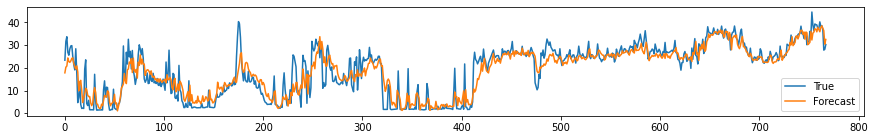

In [38]:
import matplotlib.pyplot as plt
plot_x_size = 15
plot_y_size = 2
plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]
# series[-test_size:].plot(label = 'True')
plt.plot(test_y, label = 'True')
plt.plot(forecast, label = 'Forecast')
plt.legend()
plt.show()

In [39]:
y_array = test_y
yhat_array = forecast
yList = []
yHatList = []
for idx in range(len(y_array)):
    yList.append(y_array[idx])
    yHatList.append(yhat_array[idx])

results_df = pd.DataFrame(columns=['predicted', 'observed'])
results_df['predicted'] = yHatList
results_df['observed']  = yList

# np.save('arima_office_pred.npy', results_df["predicted"])
# np.save('arima_office_true.npy', results_df["observed"])


In [40]:
# Performance metrics

def MAE(pred, true):
    return np.mean(np.abs(pred - true))

def MSE(pred, true):
    return np.mean((pred - true) ** 2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def sMAPE(pred, true):
    return 100/len(true) * np.sum(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred)))

def metric(pred, true):
    pred = np.array(pred)
    true = np.array(true)

    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    smape = sMAPE(pred, true)

    return mae, mse, rmse, mape, smape

In [41]:
results_df.head()

,predicted,observed
0,17.800843,23.356316
1,20.286925,31.638421
2,20.794146,33.691731
3,24.359700,26.810222
4,22.744594,25.560071


In [42]:
# results_df = pd.DataFrame(columns=['predicted', 'observed'])
# results_df['predicted'] = np.load('arima_renergetic_pred.npy')
# results_df['observed']  = np.load('arima_renergetic_true.npy')

# Writing the figure visalizing the predictions and ground truth with performance metrics in the disk 
fig = px.line(results_df, x=results_df.index,  y=["observed","predicted"])
fig.update_layout(
height=400, 
width=700,
xaxis_title="Horizon Time Steps",
yaxis_title="Normalized Patv",
legend_title="Variables")

mae, mse, rmse, mape, smape = metric(results_df['predicted'], results_df['observed'])
figName = "office_{:.2f}_{:.2f}_{:.2f}_{:.2f}_{:.2f}.png".format(mae, mse, rmse, mape, smape)
# figPath = os.path.join(outDirPath, figName)
fig.write_image(figName)

###  Hyperparameter Tuning

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

#### Number of Trees

 10 --- MAE: -0.291 (0.006)
 50 --- MAE: -0.070 (0.002)
100 --- MAE: -0.070 (0.002)
500 --- MAE: -0.072 (0.002)
1000 --- MAE: -0.072 (0.002)
2000 --- MAE: -0.072 (0.002)


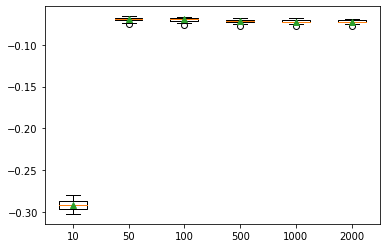

In [16]:
trees = [10, 50, 100, 500, 1000, 2000]

results = []
names = []
for i in trees:
    
    params = {
        'n_estimators': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%3d --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

#### Tree Depth

In [ ]:
results = []
names = []
for i in range(1, 11):
    
    params = {
        'max_depth': i,
        'num_leaves': 2**i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%3d --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

#### Learning Rate

In [ ]:
rates = [0.0001, 0.001, 0.01, 0.1, 1.0]

results = []
names = []
for i in rates:
    
    params = {
        'learning_rate': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%.3f --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

#### Boosting Type

- `gbdt`: Gradient Boosting Decision Tree (GDBT).
- `dart`: Dropouts meet Multiple Additive Regression Trees (DART).
- `goss`: Gradient-based One-Side Sampling (GOSS).

In [ ]:
types = ['gbdt', 'dart', 'goss']

results = []
names = []
for i in types:
    
    params = {
        'boosting_type': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%s --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

#### More than one variable...

In [ ]:
types = ['gbdt', 'dart', 'goss']

results = []
for i in types:
    
    for j in range(1, 11):
    
        params = {
            'n_estimators': 2000,
            'learning_rate': 0.1,
            'max_depth': j,
            'num_leaves': 2**j,
            'boosting_type': i,
        }

        cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
        scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
        results.append(scores)

        print('%s %d --- MAE: %.3f (%.3f)' % (i, j, np.mean(scores), np.std(scores)))

### Final Model

In [ ]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

forecast = model.predict(test_x)
s1_naive = series[-29:-1].to_numpy()
s7_naive = series[-35:-7].to_numpy()
s30_naive = series[-56:-28].to_numpy()
s365_naive = series[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

series[-test_size:].plot(marker = 'o', linestyle = '--')
plt.plot(forecast, marker = 'o', linestyle = '--')
plt.show()